## import

In [ ]:
from pathlib import Path

import albumentations as A
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchinfo
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import DataLoader

from torchlake.common.constants import VOC_CLASS_NAMES
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.controller.weight_manager import WeightManager
from torchlake.common.datasets.voc import VOCSegmentation
from torchlake.common.datasets.voc.constants import LABEL_COLORS
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.image import decode_segmap, load_image
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.common.utils.plot import plot_grids
from torchlake.semantic_segmentation.models.hdc_duc import HDCDUC, tusimple_style_resnet

d:\research\pytorch-implementations\gits\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# setting

In [2]:
artifacts_path = Path("../../artifacts/hdc-udc")
artifacts_path.mkdir(exist_ok=True)

data_path = Path("../../data")

In [3]:
DEVICE = torch.device("cuda:0")

# data

In [4]:
BATCH_SIZE = 8
IMAGE_SIZE = 320
NUM_CLASS = len(VOC_CLASS_NAMES)

In [5]:
train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),  # in feature extractor
        ToTensorV2(),
    ]
)

test_transform = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),  # in feature extractor
        ToTensorV2(),
    ]
)

In [6]:
train_dataset = VOCSegmentation(
    data_path.as_posix(),
    year="2012",
    transform=train_transform,
)

test_dataset = VOCSegmentation(
    data_path.as_posix(),
    year="2007",
    transform=test_transform,
)

In [7]:
NUM_WORKERS = get_num_workers()

In [8]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=NUM_WORKERS,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE // 2,
    num_workers=NUM_WORKERS,
)

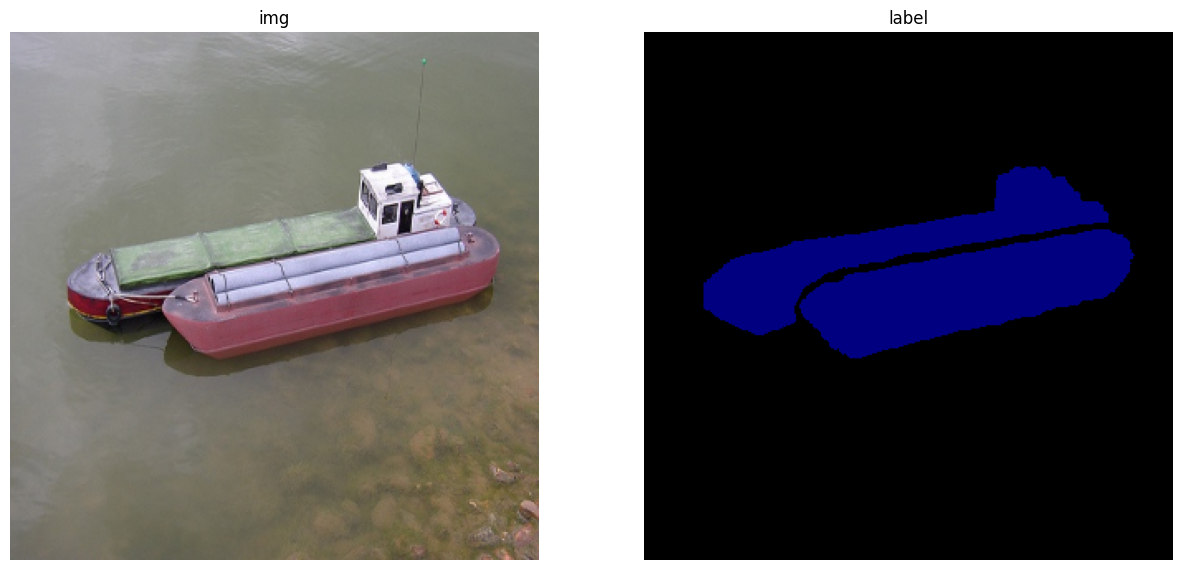

In [9]:
interest_pic = 102
img, label = train_dataset[interest_pic]

plot_grids(
    [
        img_tensor_to_np(img),
        decode_segmap(label, LABEL_COLORS),
    ],
    ["img", "label"],
    1,
    2,
    figsize=(15, 7),
)

In [10]:
row = next(iter(train_loader))
for ele in row: print(ele.shape)

torch.Size([8, 3, 320, 320])
torch.Size([8, 320, 320])


# model

In [11]:
OUTPUT_STRIDE = 8

backbone = tusimple_style_resnet("resnet101", trainable=True, output_stride=OUTPUT_STRIDE)
model = HDCDUC(backbone, output_size=NUM_CLASS + 1, output_stride=OUTPUT_STRIDE).to(DEVICE)

In [12]:
torchinfo.summary(model)

Layer (type:depth-idx)                             Param #
HDCDUC                                             --
├─ResNetFeatureExtractor: 1-1                      --
│    └─Sequential: 2-1                             --
│    │    └─Conv2d: 3-1                            9,408
│    │    └─BatchNorm2d: 3-2                       128
│    │    └─ReLU: 3-3                              --
│    │    └─MaxPool2d: 3-4                         --
│    │    └─Sequential: 3-5                        215,808
│    │    └─Sequential: 3-6                        1,219,584
│    │    └─Sequential: 3-7                        26,090,496
│    │    └─Sequential: 3-8                        14,964,736
│    └─ImageNetNormalization: 2-2                  --
├─DUC: 1-2                                         --
│    └─ModuleList: 2-3                             --
│    │    └─Conv2d: 3-9                            24,773,952
│    │    └─Conv2d: 3-10                           24,773,952
│    │    └─Conv2d: 3-11     

# train

In [13]:
EPOCHS = 30

In [14]:
trainer = ClassificationTrainer(EPOCHS, DEVICE)
trainer.recorder.increment_data_size(len(train_dataset))

In [15]:
criterion = trainer.get_criterion(NUM_CLASS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [16]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, threshold=.05 ,threshold_mode ='rel')

In [17]:
# scaler = torch.amp.grad_scaler.GradScaler(DEVICE)

In [18]:
training_loss = trainer.run(
    train_loader,
    model,
    optimizer,
    criterion,
    scheduler,
    # scaler=scaler,
)

Enable AMP: False
Training...


100%|██████████| 364/364 [05:09<00:00,  1.18it/s]


------------------------------------
Epoch 1
------------------------------------
total: 7.3199e-02 (0.00%)


100%|██████████| 364/364 [05:19<00:00,  1.14it/s]


------------------------------------
Epoch 2
------------------------------------
total: 3.6483e-02 (-50.00%)


100%|██████████| 364/364 [05:18<00:00,  1.14it/s]


------------------------------------
Epoch 3
------------------------------------
total: 2.6540e-02 (-27.00%)


100%|██████████| 364/364 [05:07<00:00,  1.19it/s]


------------------------------------
Epoch 4
------------------------------------
total: 2.1882e-02 (-18.00%)


100%|██████████| 364/364 [05:16<00:00,  1.15it/s]


------------------------------------
Epoch 5
------------------------------------
total: 1.9217e-02 (-12.00%)


100%|██████████| 364/364 [05:30<00:00,  1.10it/s]


------------------------------------
Epoch 6
------------------------------------
total: 1.6598e-02 (-14.00%)


100%|██████████| 364/364 [05:26<00:00,  1.12it/s]


------------------------------------
Epoch 7
------------------------------------
total: 1.4335e-02 (-14.00%)


100%|██████████| 364/364 [04:04<00:00,  1.49it/s]


------------------------------------
Epoch 8
------------------------------------
total: 1.3008e-02 (-9.00%)


100%|██████████| 364/364 [05:02<00:00,  1.20it/s]


------------------------------------
Epoch 9
------------------------------------
total: 1.1847e-02 (-9.00%)


100%|██████████| 364/364 [05:33<00:00,  1.09it/s]


------------------------------------
Epoch 10
------------------------------------
total: 1.1038e-02 (-7.00%)


100%|██████████| 364/364 [04:47<00:00,  1.27it/s]


------------------------------------
Epoch 11
------------------------------------
total: 1.0188e-02 (-8.00%)


100%|██████████| 364/364 [05:10<00:00,  1.17it/s]


------------------------------------
Epoch 12
------------------------------------
total: 9.3715e-03 (-8.00%)


100%|██████████| 364/364 [04:47<00:00,  1.26it/s]


------------------------------------
Epoch 13
------------------------------------
total: 9.2904e-03 (-1.00%)


100%|██████████| 364/364 [04:46<00:00,  1.27it/s]


------------------------------------
Epoch 14
------------------------------------
total: 8.6536e-03 (-7.00%)


100%|██████████| 364/364 [04:52<00:00,  1.24it/s]


------------------------------------
Epoch 15
------------------------------------
total: 9.9725e-03 (15.00%)


100%|██████████| 364/364 [04:11<00:00,  1.45it/s]


------------------------------------
Epoch 16
------------------------------------
total: 1.2349e-02 (24.00%)


100%|██████████| 364/364 [04:28<00:00,  1.35it/s]


------------------------------------
Epoch 17
------------------------------------
total: 1.0698e-02 (-13.00%)


100%|██████████| 364/364 [04:43<00:00,  1.29it/s]


------------------------------------
Epoch 18
------------------------------------
total: 7.8301e-03 (-27.00%)


100%|██████████| 364/364 [03:27<00:00,  1.76it/s]


------------------------------------
Epoch 19
------------------------------------
total: 7.1207e-03 (-9.00%)


100%|██████████| 364/364 [03:24<00:00,  1.78it/s]


------------------------------------
Epoch 20
------------------------------------
total: 7.0199e-03 (-1.00%)


100%|██████████| 364/364 [03:26<00:00,  1.76it/s]


------------------------------------
Epoch 21
------------------------------------
total: 6.6186e-03 (-6.00%)


100%|██████████| 364/364 [03:27<00:00,  1.76it/s]


------------------------------------
Epoch 22
------------------------------------
total: 6.1567e-03 (-7.00%)


100%|██████████| 364/364 [03:27<00:00,  1.76it/s]


------------------------------------
Epoch 23
------------------------------------
total: 5.8422e-03 (-5.00%)


100%|██████████| 364/364 [03:25<00:00,  1.77it/s]


------------------------------------
Epoch 24
------------------------------------
total: 5.6155e-03 (-4.00%)


100%|██████████| 364/364 [03:33<00:00,  1.71it/s]


------------------------------------
Epoch 25
------------------------------------
total: 5.4090e-03 (-4.00%)


100%|██████████| 364/364 [03:32<00:00,  1.72it/s]


------------------------------------
Epoch 26
------------------------------------
total: 5.2747e-03 (-2.00%)


100%|██████████| 364/364 [03:28<00:00,  1.74it/s]


------------------------------------
Epoch 27
------------------------------------
total: 5.2536e-03 (0.00%)


100%|██████████| 364/364 [04:37<00:00,  1.31it/s]


------------------------------------
Epoch 28
------------------------------------
total: 1.1778e-02 (124.00%)


100%|██████████| 364/364 [04:53<00:00,  1.24it/s]


------------------------------------
Epoch 29
------------------------------------
total: 9.8859e-03 (-16.00%)


100%|██████████| 364/364 [04:48<00:00,  1.26it/s]

------------------------------------
Epoch 30
------------------------------------
total: 6.0800e-03 (-38.00%)


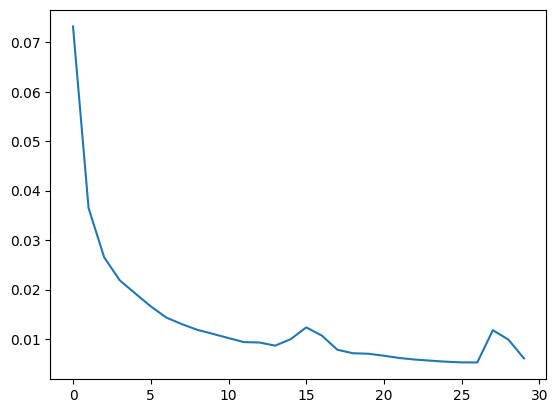

In [19]:
plt.plot(training_loss)

In [20]:
wm = WeightManager(artifacts_path.joinpath('hdc-udc.{backbone}.pth').as_posix())

In [21]:
model_path = wm.get_filename(backbone=backbone.network_name)
model_path

WindowsPath('../../artifacts/hdc-udc/hdc-udc.resnet101.pth')

In [22]:
torch.save(model.state_dict(), model_path)

In [23]:
get_file_size(model_path)

'540.77MiB'

In [24]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

# inference

### mIOU

In [25]:
from torchmetrics.classification import jaccard

metric = jaccard.MulticlassJaccardIndex(NUM_CLASS + 1, average=None)

In [26]:
evaluator = ClassificationEvaluator(NUM_CLASS+1, DEVICE)

In [27]:
metric = evaluator.run(test_loader, model, metric)

100%|██████████| 158/158 [00:23<00:00,  6.73it/s]


In [28]:
for class_name, value in zip(VOC_CLASS_NAMES, metric.compute()[1:].mul(100).round().tolist()):
    print("{:<15}: {:<5}".format(class_name, value / 100))

print("----------------------")
print("{:<15}: {:<5}".format("total", metric.compute()[1:].mean().mul(100).round().item()/100))

aeroplane      : 0.93 
bicycle        : 0.74 
bird           : 0.95 
boat           : 0.92 
bottle         : 0.93 
bus            : 0.98 
car            : 0.94 
cat            : 0.96 
chair          : 0.86 
cow            : 0.93 
diningtable    : 0.95 
dog            : 0.93 
horse          : 0.89 
motorbike      : 0.91 
person         : 0.94 
pottedplant    : 0.75 
sheep          : 0.85 
sofa           : 0.95 
train          : 0.95 
tvmonitor      : 0.97 
----------------------
total          : 0.91 


(<Figure size 640x480 with 1 Axes>, <Axes: ylabel='MulticlassJaccardIndex'>)

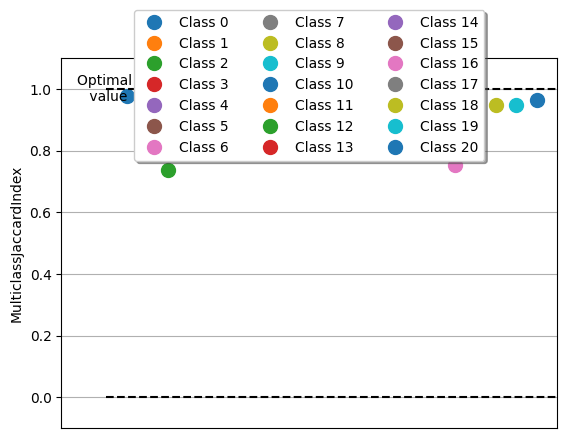

In [29]:
metric.plot()

### for image in dataset

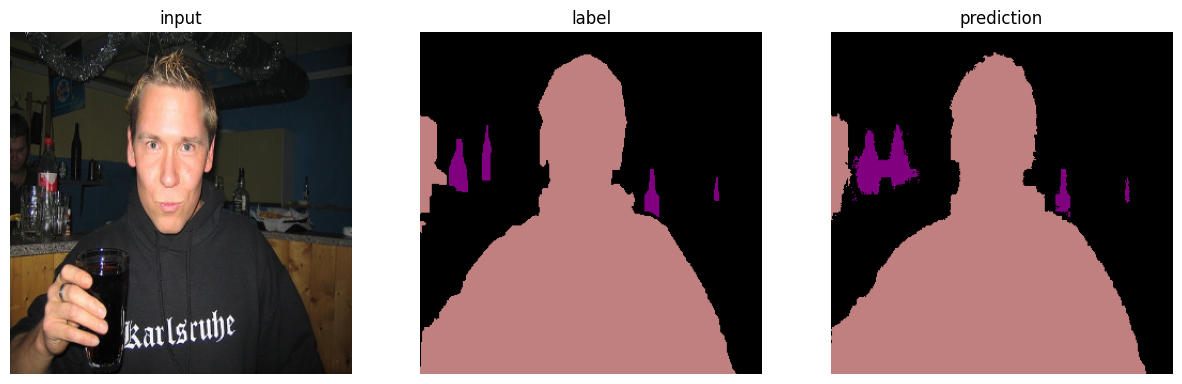

In [30]:
interest_pic = 10

model.eval()
with torch.no_grad():
    target_img, target_label = test_dataset[interest_pic]

    output = model(target_img.unsqueeze(0).to(DEVICE))
    output = output.squeeze(0).permute(1, 2, 0).argmax(dim=2).detach().cpu()

plot_grids(
    [
        img_tensor_to_np(target_img),
        decode_segmap(target_label.numpy(), LABEL_COLORS),
        decode_segmap(output.numpy(), LABEL_COLORS),
    ],
    ["input", "label", "prediction"],
    1,
    3,
    figsize=(15, 15),
)

### for any image

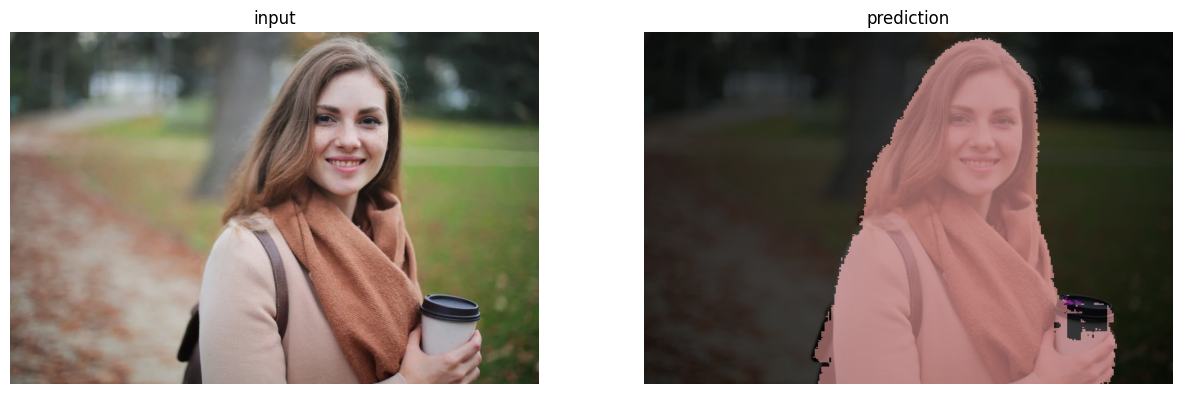

In [31]:
model.eval()
with torch.no_grad():
    target_img = load_image(data_path.joinpath("person.webp"), is_numpy=True)

    h, w, c = target_img.shape
    test_img = test_transform(image=target_img)["image"]
    output = model(test_img.unsqueeze(0).to(DEVICE))
    output = output.argmax(dim=1, keepdim=True)
    # B, C, H, W
    output = F.interpolate(output.float(), size=(h, w), mode="nearest")
    # 1, 1, h, w
    output = output.squeeze(0, 1).detach().cpu().numpy()

    coef = 0.7
    mask = decode_segmap(output, LABEL_COLORS)
    overlay_image = target_img.copy()
    for channel_idx in range(c):
        overlay_image[: , : ,channel_idx] = overlay_image[: , : ,channel_idx] * (1 - coef) + mask[: , : ,channel_idx] * coef


    plot_grids(
        [
            target_img,
            overlay_image,
        ],
        ["input", "prediction"],
        1,
        2,
        figsize=(15, 15),
    )